# Exploring ensembling different sized models on uncertainty measures 

In [1]:
import pandas as pd
import numpy as np
from scipy.special import rel_entr
from scipy.stats import entropy
import matplotlib.pyplot as plt
from matplotlib_venn import venn3,venn2

In [2]:
# Load data:
df18 = pd.read_csv("../exp1-inf/predictions_res18.csv")
df101 = pd.read_csv("../exp1-inf/predictions_res101.csv")
label = pd.read_csv("../exp1-inf/labels.csv")
num_class = 257
pred = pd.DataFrame({
    "pred18": np.argmax(df18,axis=1),
    "pred101": np.argmax(df101,axis=1),
    "target": label['target']
})
print(f"{df18.shape=}")
display(df18.head(1))
print(f"{df101.shape=}")
display(df101.head(1))
print(f"{pred.shape=}")
display(pred.head(1))

df18.shape=(10000, 100)


,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,...,class_90,class_91,class_92,class_93,class_94,class_95,class_96,class_97,class_98,class_99
0,0.000101,0.000075,0.000086,0.00016,0.000048,0.000025,0.000091,0.000074,0.000031,0.000038,...,0.000223,0.000075,0.000021,0.000102,0.000051,0.000022,0.000055,0.000154,0.000064,0.000072


df101.shape=(10000, 100)


,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,...,class_90,class_91,class_92,class_93,class_94,class_95,class_96,class_97,class_98,class_99
0,0.002251,0.001926,0.002115,0.001981,0.0047,0.002163,0.00371,0.005516,0.002965,0.004178,...,0.013644,0.001995,0.001647,0.001674,0.001807,0.002392,0.003219,0.002994,0.007412,0.002566


pred.shape=(10000, 3)


,pred18,pred101,target
0,68,68,49


In [3]:
def eval_pred(pred):
    for col in pred.columns.drop("target"):
        acc = (pred[col]==pred["target"]).mean()
        print(f"{col} has accuracy {acc}")
eval_pred(pred)

pred18 has accuracy 0.4668
pred101 has accuracy 0.5112


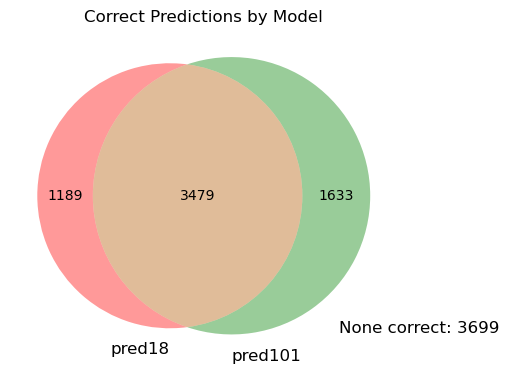

In [4]:
def venn(pred):
    # Accuracy Venn Diagram:
    df = pred
    ls = []
    total_indices = set(df.index)
    incorrect_all = total_indices
    col_names=[]
    for col in df.columns.drop("target"):
        col_names.append(col)
        cor_set = set(df[df[col] == df['target']].index)
        ls.append(cor_set)
        incorrect_all = incorrect_all - cor_set
    plt.figure(figsize=(5,5))
    if len(col_names)==2:
        venn2(ls, col_names)
    elif len(col_names)==3:
        venn3(ls, col_names)
    else:
        raise Exception("Matplotlib Venn only supports 2 or 3 sets, please subset to 3 predictions columns and target.")
    plt.title('Correct Predictions by Model')
    plt.text(0.5, -0.5, f'None correct: {len(incorrect_all)}', fontsize=12)
venn(pred)

# Approach 1: Classical Voting
**Hard Voting (Plurality Voting)**: Selecting the class that receives the most votes as the final prediction. The problem with hard voting here is that we only have two models.  
**Soft Voting (Weighted Voting with uniform weights)**: Calculates the average probability of each class and then declares the winner having the highest weighted probability.  
**Weighted Voting (with validation accuracy as weights)**: Calculates weighted probability of each class based on validation accuracy, and then selecting the class with highest weighted probability

In [5]:
# Soft Voting
def soft_vote(pred1, pred2):
    sum_pred = pred1+pred2
    return np.argmax(sum_pred,axis=1)
pred["soft_vote"] = soft_vote(df18, df101)
display(pred.head(1))
eval_pred(pred)

,pred18,pred101,target,soft_vote
0,68,68,49,68


pred18 has accuracy 0.4668
pred101 has accuracy 0.5112
soft_vote has accuracy 0.5473


In [6]:
# Soft Voting
def weighted_vote(pred1, pred2, weight1, weight2):
    weighted_pred = np.multiply(weight1,pred1)+np.multiply(weight2,pred2)
    return np.argmax(weighted_pred,axis=1)
pred["weighted_vote"] = weighted_vote(df18, df101, 0.75, 0.87)
display(pred.head(1))
eval_pred(pred)

,pred18,pred101,target,soft_vote,weighted_vote
0,68,68,49,68,68


pred18 has accuracy 0.4668
pred101 has accuracy 0.5112
soft_vote has accuracy 0.5473
weighted_vote has accuracy 0.5448


# Approach 2: Uncertainty Voting
We propose an alternative aggregation strategy based on KL Divergence, Entropy, and Cross Entropy among the two models.

In [7]:
# Generate 2 KL Columns, 2 Entropy Columns, 2 Cross-Entropy Columns
unc_pred = pred.copy()
def calc_kl(P,Q,numclass):
    return rel_entr(P.iloc[:,0:numclass],Q.iloc[:,0:numclass]).sum(1)
unc_pred["kl_18_101"] = calc_kl(df18,df101,num_class)
unc_pred["kl_101_18"] = calc_kl(df101,df18,num_class)
def calc_entropy(P,numclass):
    return entropy(P.iloc[:,0:numclass],axis=1)
unc_pred["ent_18"] = calc_entropy(df18,num_class)
unc_pred["ent_101"] = calc_entropy(df101,num_class)
def calc_cross_ent(P,Q,numclass):
    return np.log(entropy(P.iloc[:,0:numclass],Q.iloc[:,0:numclass],axis=1))
unc_pred["ce_18_101"] = calc_cross_ent(df18,df101,num_class)
unc_pred["ce_101_18"] = calc_cross_ent(df18,df101,num_class)
unc_pred.head()

,pred18,pred101,target,soft_vote,weighted_vote,kl_18_101,kl_101_18,ent_18,ent_101,ce_18_101,ce_101_18
0,68,68,49,68,68,0.957978,3.051359,0.104553,2.887301,-0.042930,-0.042930
1,9,88,33,9,9,1.063623,1.602684,2.192025,2.496735,0.061682,0.061682
2,72,4,72,4,4,3.883613,5.411646,1.826138,1.861975,1.356766,1.356766
3,21,51,51,51,51,4.474733,3.389089,2.579214,0.873690,1.498447,1.498447
4,71,71,71,71,71,0.990844,0.342718,1.042726,0.066595,-0.009198,-0.009198


**Method 1** We select the prediction of the model with lower entropy (i.e. lower uncertainty) This is a flavor of hard voting, as in it is not going to predict anything that isn't already a top prediction of either model.

pred18 has accuracy 0.4668
pred101 has accuracy 0.5112
soft_vote has accuracy 0.5473
weighted_vote has accuracy 0.5448
min_entropy_pred has accuracy 0.5413


/Users/timothyzhou/anaconda3/envs/cpsc340/lib/python3.11/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


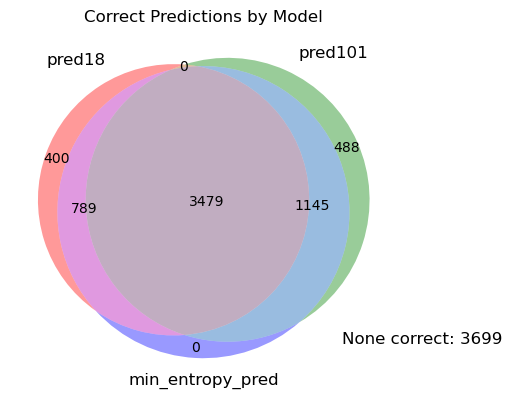

In [8]:
pred["min_entropy_pred"] = np.where(unc_pred["ent_18"]>unc_pred["ent_101"],pred["pred101"],pred["pred18"])
pred.head(1)
eval_pred(pred)
venn(pred[["pred18","pred101","min_entropy_pred","target"]])

**Method 2** We combine the predictions of models by assigning the other model's entropy as weights, i.e a model receives more weights when the other models is uncertain.

In [9]:
def vec_weighted_vote(pred1, pred2, weightvec1, weightvec2):
    weighted_pred = pred1.mul(weightvec1, axis=0) + pred2.mul(weightvec2, axis=0)
    return np.argmax(weighted_pred,axis=1)

pred["unc_weighted_vote"] = vec_weighted_vote(df18, df101, unc_pred["ent_101"], unc_pred["ent_18"])

display(pred.head(1))
eval_pred(pred)

,pred18,pred101,target,soft_vote,weighted_vote,min_entropy_pred,unc_weighted_vote
0,68,68,49,68,68,68,68


pred18 has accuracy 0.4668
pred101 has accuracy 0.5112
soft_vote has accuracy 0.5473
weighted_vote has accuracy 0.5448
min_entropy_pred has accuracy 0.5413
unc_weighted_vote has accuracy 0.5455


In [10]:
pred["kl_weighted_vote"] = vec_weighted_vote(df18, df101, unc_pred["kl_101_18"], unc_pred["kl_18_101"])
display(pred.head(1))
eval_pred(pred)

,pred18,pred101,target,soft_vote,weighted_vote,min_entropy_pred,unc_weighted_vote,kl_weighted_vote
0,68,68,49,68,68,68,68,68


pred18 has accuracy 0.4668
pred101 has accuracy 0.5112
soft_vote has accuracy 0.5473
weighted_vote has accuracy 0.5448
min_entropy_pred has accuracy 0.5413
unc_weighted_vote has accuracy 0.5455
kl_weighted_vote has accuracy 0.5553
